In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import gmaps
import time
import sys
import os
from pprint import pprint
from scipy import stats

from config import api_key

from citipy import citipy

output_data_file = "output_data/cities.csv"

lat_range = (-90, 90)
lng_range = (-180, 180)

In [33]:
url = "http://api.openweathermap.org/data/2.5/weather?"

In [38]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print(f"Number of cities: {len(cities)}")

607

In [152]:
def get_weather(cities_arr, url, units):
    cities = []
    lats = []
    lngs = []
    temps = []
    rhs = []
    clouds = []
    winds = []
    
    successes = 0
    failures = 0
    
    for city in cities_arr:
        query_url = f"{url}q={city}&units={units}&appid={api_key}"
        response = requests.get(query_url).json()
        try:
            cities.append(response['name'])
            lats.append(response['coord']['lat'])
            lngs.append(response['coord']['lon'])
            temps.append(response['main']['temp'])
            rhs.append(response['main']['humidity'])
            clouds.append(response['clouds']['all'])
            winds.append(response['wind']['speed'])
            successes += 1
            print(f"Success (city #{successes + failures}, name: {response['name']})")
        except:
            failures += 1
            print(f"ERROR!!!! (city #{successes + failures}, name: {city})")
            pass
    
    success_pct = round(100 * successes / (successes + failures), 2)
    print("-----------------------------------------------------------")
    print(f"Successfully retrieved {successes} cities ({success_pct}%)")
    
    return {
        'City': cities,
        'Latitude': lats,
        'Longitude': lngs,
        'Temperature (F)': temps,
        'Humidity (%)': rhs,
        'Cloudiness (%)': clouds,
        'Wind Speed (mph)': winds
    }

In [154]:
results = get_weather(cities, url, 'imperial')

Success (city #1, name: Ribeira Grande)
Success (city #2, name: Okhotsk)
Success (city #3, name: Albany)
Success (city #4, name: Vaini)
Success (city #5, name: Nacala)
Success (city #6, name: Imbituba)
Success (city #7, name: Fortuna)
Success (city #8, name: Ushuaia)
Success (city #9, name: Barrow)
Success (city #10, name: Dikson)
Success (city #11, name: Quatre Cocos)
Success (city #12, name: Alcúdia)
ERROR!!!! (city #13, name: dolbeau)
ERROR!!!! (city #14, name: saleaula)
Success (city #15, name: Sibolga)
Success (city #16, name: Port Alfred)
Success (city #17, name: Houma)
ERROR!!!! (city #18, name: mys shmidta)
Success (city #19, name: East London)
Success (city #20, name: Souillac)
Success (city #21, name: Hong Kong)
Success (city #22, name: Husavik)
Success (city #23, name: Belyy Yar)
Success (city #24, name: Lüderitz)
Success (city #25, name: Qingdao)
ERROR!!!! (city #26, name: belushya guba)
ERROR!!!! (city #27, name: taolanaro)
Success (city #28, name: Busselton)
Success (city

Success (city #225, name: Lusambo)
Success (city #226, name: Shar)
Success (city #227, name: Badak)
Success (city #228, name: Saiha)
Success (city #229, name: Flinders)
Success (city #230, name: Malinovka)
Success (city #231, name: Havøysund)
Success (city #232, name: Yar-Sale)
Success (city #233, name: Hirara)
Success (city #234, name: Mathathane)
Success (city #235, name: Robertsport)
Success (city #236, name: Naze)
ERROR!!!! (city #237, name: tabiauea)
Success (city #238, name: Huarmey)
Success (city #239, name: Alyangula)
Success (city #240, name: Sørland)
Success (city #241, name: Ostrovnoy)
Success (city #242, name: La Ronge)
Success (city #243, name: Anzio)
Success (city #244, name: Lázaro Cárdenas)
Success (city #245, name: Pisco)
Success (city #246, name: Padang)
Success (city #247, name: Kruisfontein)
ERROR!!!! (city #248, name: karkaralinsk)
Success (city #249, name: Pemangkat)
Success (city #250, name: Bloemfontein)
Success (city #251, name: Boyolangu)
Success (city #252, n

Success (city #450, name: South Lake Tahoe)
Success (city #451, name: Singleton)
Success (city #452, name: Nyköping)
Success (city #453, name: Ambilobe)
Success (city #454, name: Saint Anthony)
Success (city #455, name: Puerto Carreño)
ERROR!!!! (city #456, name: ijaki)
Success (city #457, name: Cabo San Lucas)
Success (city #458, name: Peace River)
Success (city #459, name: Hambantota)
Success (city #460, name: Izhma)
Success (city #461, name: Florianópolis)
Success (city #462, name: Biak)
Success (city #463, name: Kirakira)
Success (city #464, name: Salamá)
Success (city #465, name: Skovorodino)
Success (city #466, name: Taihe)
Success (city #467, name: Banda Aceh)
Success (city #468, name: Harlingen)
ERROR!!!! (city #469, name: kuche)
Success (city #470, name: Korla)
Success (city #471, name: Kadaya)
ERROR!!!! (city #472, name: marcona)
Success (city #473, name: Trofors)
Success (city #474, name: Vila do Maio)
Success (city #475, name: Tamala)
Success (city #476, name: Avera)
Succes

In [155]:
results_df = pd.DataFrame(results)
results_df.head()

,City,Latitude,Longitude,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph)
0,Ribeira Grande,38.52,-28.70,66.63,83,72,10.38
1,Okhotsk,59.38,143.30,37.87,82,100,16.33
2,Albany,42.60,-73.97,49.01,73,37,11.99
3,Vaini,-21.20,-175.20,75.20,88,90,11.41
4,Nacala,-14.54,40.67,73.74,90,0,2.15


In [312]:
def lat_scat(lat, y, scope, color, alpha, filename):
    
    plt.scatter(lat, y, color=color, alpha=alpha)
    plt.title(f"Latitude vs {y.name}, {scope}")
    plt.xlabel('Degrees from equator')
    plt.ylabel(y.name)
    plt.ylim(0, y.max() + y.max() / 20)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(lat, y)
    x_vals = results_df['Latitude'].abs()
    plt.plot(x_vals, x_vals * slope + intercept, color=color)
    
    plt.savefig(f"output/{filename}.png")
    plt.show()
    return (r_value ** 2, slope)

In [298]:
lat_abs = results_df['Latitude'].abs()
g_scope = 'Global'

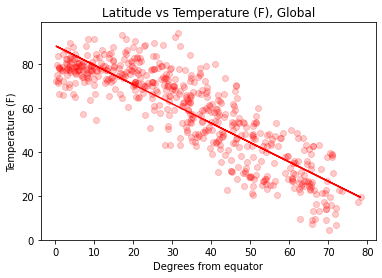

As you would expect, temperature drops as you get farther from the equator, after an initial plateau.
 - R-squared: 0.746
 - Slope: -0.88


In [313]:
# Scatter plot for temp vs latitude

r_sq, slp = lat_scat(lat_abs, results_df['Temperature (F)'], g_scope, 'red', 0.2, 'temp_lat_global')

explanation = "As you would expect, temperature drops as you get farther from the equator, after an initial plateau."
print(explanation)
print(f" - R-squared: {round(r_sq, 3)}")
print(f" - Slope: {round(slp, 3)}")

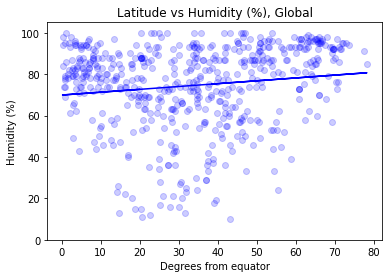

Humidity is relative to temperature, so it makes sense it doesn't change much as you go to colder latitudes
 - R-squared: 0.019
 - Slope: 0.138


In [316]:
# Scatter plot for humidity vs latitude

r_sq, slp = lat_scat(lat_abs, results_df['Humidity (%)'], g_scope, 'blue', 0.2, 'rh_lat_global')

explanation = "Humidity is relative to temperature, so it makes sense it doesn't change much as you go to colder latitudes"
print(explanation)
print(f" - R-squared: {round(r_sq, 3)}")
print(f" - Slope: {round(slp, 3)}")

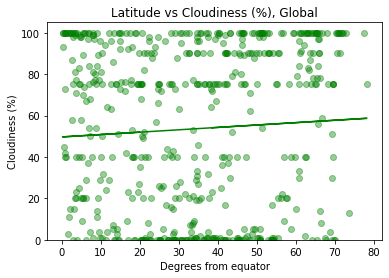

Even more negligible relationship between latitude and cloudiness
 - R-squared: 0.004
 - Slope: 0.115


In [315]:
# Scatter plot for cloudiness vs latitude

r_sq, slp = lat_scat(lat_abs, results_df['Cloudiness (%)'], g_scope, 'green', 0.4, 'cloud_lat_global')

explanation = "Even more negligible relationship between latitude and cloudiness"
print(explanation)
print(f" - R-squared: {round(r_sq, 3)}")
print(f" - Slope: {round(slp, 3)}")

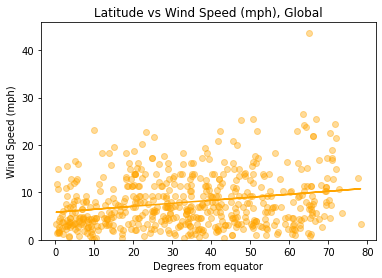

Max wind speed is certainly higher as you get farther from the equator, but average doesn't change much
 - R-squared: 0.052
 - Slope: 0.063


In [317]:
# Scatter plot for wind speed vs latitude

r_sq, slp = lat_scat(lat_abs, results_df['Wind Speed (mph)'], g_scope, 'orange', 0.4, 'wind_lat_global')

explanation = "Max wind speed is certainly higher as you get farther from the equator, but average doesn't change much"
print(explanation)
print(f" - R-squared: {round(r_sq, 3)}")
print(f" - Slope: {round(slp, 3)}")

In [305]:
n_hem_df = results_df.loc[results_df['Latitude'] > 0]
n_lat_abs = n_hem_df['Latitude'].abs()
n_scope = 'Northern Hemisphere'

s_hem_df = results_df.loc[results_df['Latitude'] < 0]
s_lat_abs = s_hem_df['Latitude'].abs()
s_scope = 'Southern Hemisphere'

caveat = "The Southern hemisphere has a lot less land mass (and cities), especially as you get closer to Antarctica. As you can see in the plots below, the highest latitude in this dataset is nearly 80 degrees in the Northern hemisphere, but less than 60 in the Southern hemisphere - so take "
print(caveat)

The Southern hemisphere has a lot less land mass (and cities), especially as you get closer to Antarctica. As you can see in the plots below, the highest latitude in this dataset is nearly 80 degrees in the Northern hemisphere, but less than 60 in the Southern hemisphere - so take 


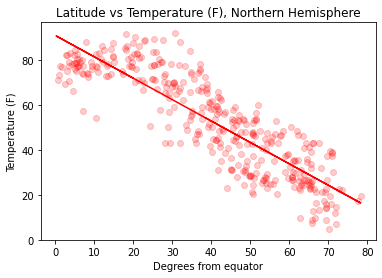

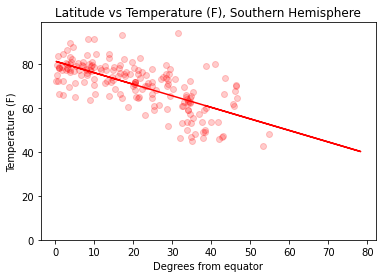

The Southern hemisphere is closer summer that we are, there is less of a dropoff in temperature as you get closer to the equator
 - R-squared: Northern: 0.755, Southern: 0.452
 - Slope: Northern: -0.951, Southern: -0.524


In [318]:
# Scatter plot for temp vs latitude

r_sq_n, slp_n = lat_scat(n_lat_abs, n_hem_df['Temperature (F)'], n_scope, 'red', 0.2, 'temp_lat_north')
r_sq_s, slp_s = lat_scat(s_lat_abs, s_hem_df['Temperature (F)'], s_scope, 'red', 0.2, 'temp_lat_south')

explanation = "The Southern hemisphere is closer summer that we are, there is less of a dropoff in temperature as you get closer to the equator"
print(explanation)
print(f" - R-squared: Northern: {round(r_sq_n, 3)}, Southern: {round(r_sq_s, 3)}")
print(f" - Slope: Northern: {round(slp_n, 3)}, Southern: {round(slp_s, 3)}")

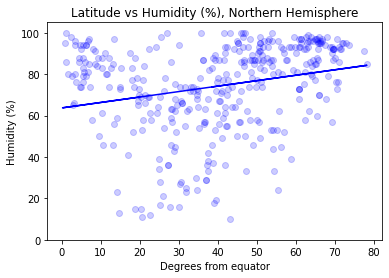

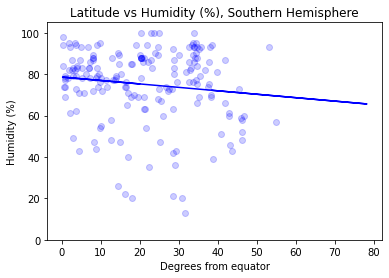

High positive latitudes are a little more humid than high negative latitudes, but the relationship is week
 - R-squared: Northern: 0.061, Southern: 0.016
 - Slope: Northern: 0.263, Southern: -0.166


In [320]:
# Scatter plot for humidity vs latitude

r_sq_n, slp_n = lat_scat(n_lat_abs, n_hem_df['Humidity (%)'], n_scope, 'blue', 0.2, 'rh_lat_north')
r_sq_s, slp_s = lat_scat(s_lat_abs, s_hem_df['Humidity (%)'], s_scope, 'blue', 0.2, 'rh_lat_south')

explanation = "High positive latitudes are a little more humid than high negative latitudes, but the relationship is week"
print(explanation)
print(f" - R-squared: Northern: {round(r_sq_n, 3)}, Southern: {round(r_sq_s, 3)}")
print(f" - Slope: Northern: {round(slp_n, 3)}, Southern: {round(slp_s, 3)}")

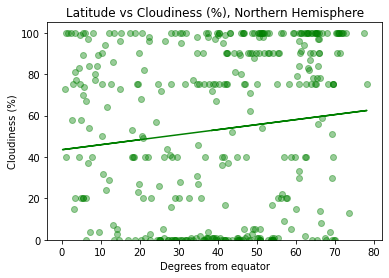

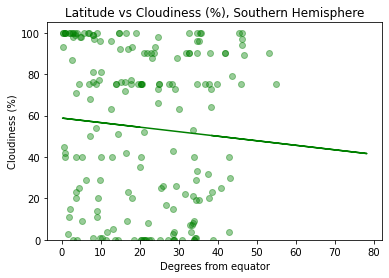

The data is messy, but with more landmass in the arctic circle than the antarctic, you might expect more clouds
 - R-squared: Northern: 0.015, Southern: 0.006
 - Slope: Northern: 0.242, Southern: -0.219


In [326]:
# Scatter plot for cloudiness vs latitude

r_sq_n, slp_n = lat_scat(n_lat_abs, n_hem_df['Cloudiness (%)'], n_scope, 'green', 0.4, 'cloud_lat_north')
r_sq_s, slp_s = lat_scat(s_lat_abs, s_hem_df['Cloudiness (%)'], s_scope, 'green', 0.4, 'cloud_lat_south')

explanation = "The data is messy, but with more landmass in the arctic circle than the antarctic, you might expect more clouds"
print(explanation)
print(f" - R-squared: Northern: {round(r_sq_n, 3)}, Southern: {round(r_sq_s, 3)}")
print(f" - Slope: Northern: {round(slp_n, 3)}, Southern: {round(slp_s, 3)}")

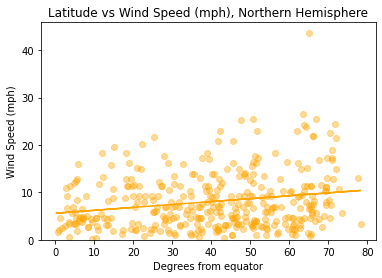

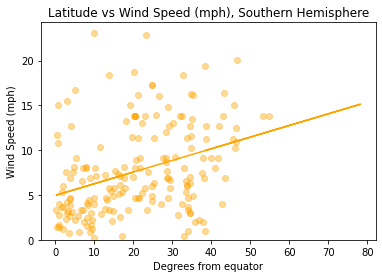

Hard to judge trends here, but winds in the Southern hemisphere seem to more reliably increase further from the equator
 - R-squared: Northern: 0.043, Southern: 0.124
 - Slope: Northern: 0.061, Southern: 0.13


In [325]:
# Scatter plot for wind speed vs latitude

r_sq_n, slp_n = lat_scat(n_lat_abs, n_hem_df['Wind Speed (mph)'], n_scope, 'orange', 0.4, 'wind_lat_north')
r_sq_s, slp_s = lat_scat(s_lat_abs, s_hem_df['Wind Speed (mph)'], s_scope, 'orange', 0.4, 'wind_lat_south')

explanation = "Hard to judge trends here, but winds in the Southern hemisphere seem to more reliably increase further from the equator"
print(explanation)
print(f" - R-squared: Northern: {round(r_sq_n, 3)}, Southern: {round(r_sq_s, 3)}")
print(f" - Slope: Northern: {round(slp_n, 3)}, Southern: {round(slp_s, 3)}")

In [329]:
results_df.set_index('City').to_csv('../VacationPy/resources/city_results.csv')